Sign Language Project Computer Vision Dataset

https://universe.roboflow.com/sign-language-colorful/sign-language-project-zxbft

In [ ]:
# Install dependencies
!pip install -q ultralytics roboflow supervision pandas matplotlib

In [12]:
# Install library
import os
from google.colab import userdata
from pathlib import Path
import yaml
import pandas as pd
import numpy as np
from roboflow import Roboflow
from ultralytics import YOLO
import shutil
import cv2

In [13]:
# Load API required

# Import Roboflow API
os.environ["ROBOFLOW_API_KEY"] = userdata.get('ROBOFLOW_API_KEY')
ROBOFLOW_API_KEY = os.environ["ROBOFLOW_API_KEY"]

In [4]:
# Load first dataset (Object Detection)

rf_1 = Roboflow(api_key=ROBOFLOW_API_KEY)
project_1 = rf_1.workspace("test-hmtgo").project("sign-language-project-zxbft-ekfrd")
version_1 = project_1.version(1)
dataset_1 = version_1.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Sign-Language-Project-1 in yolov8:: 100%|██████████| 7212/7212 [00:01<00:00, 4454.21it/s]


In [5]:
# Set out directory for object detection

HOME = os.getcwd()
base_path = Path(HOME)
first_dataset_location = base_path / "Sign-Language-Project-1"
yaml_data = first_dataset_location / "data.yaml"

In [6]:
# Function for restructuring data.yaml so it would convert from 36 class into 1 class (hand) only

def convert_yolo_labels_to_single_class(
    dataset_root: str,
    target_class_id: int = 0,
    dry_run: bool = False
):
    """
    Convert all YOLO label files in train/valid/test splits to a single class.
    """
    dataset_root = Path(dataset_root)
    splits = ["train", "valid", "test"]

    for split in splits:
        labels_dir = dataset_root / split / "labels"
        if not labels_dir.exists():
            continue

        print(f"\nProcessing {labels_dir}")

        for label_file in labels_dir.glob("*.txt"):
            with open(label_file, "r") as f:
                lines = f.readlines()

            new_lines = []
            changed = False

            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue

                if parts[0] != str(target_class_id):
                    parts[0] = str(target_class_id)
                    changed = True

                new_lines.append(" ".join(parts))

            if changed:
                if dry_run:
                    print(f"Dry Run Would update {label_file.name}")
                else:
                    with open(label_file, "w") as f:
                        f.write("\n".join(new_lines))
                    print(f"Updated {label_file.name}")


def update_data_yaml_to_single_class(
    yaml_path: str,
    class_name: str = "hand"
):
    with open(yaml_path, "r") as f:
        data = yaml.safe_load(f)

    data["nc"] = 1
    data["names"] = {0: class_name}

    with open(yaml_path, "w") as f:
        yaml.safe_dump(data, f)

    print(f"Updated {yaml_path}")

In [7]:
# Convert all label files to class 0
convert_yolo_labels_to_single_class(
    dataset_root="Sign-Language-Project-1",
    target_class_id=0
)
# Convert data.yaml to 1-class
update_data_yaml_to_single_class(
    yaml_path="Sign-Language-Project-1/data.yaml",
    class_name="hand"
)


Processing Sign-Language-Project-1/train/labels
Updated 3_e1c46a35-dc6f-11ed-a60b-b07d6448fdf4_png.rf.e199b7936544e0472c469e6347a36c75.txt
Updated B_7f031b07-d973-11ed-846e-b07d6448fdf4_jpg.rf.01bac13058cbed29bcd9a6809531f05b.txt
Updated 6_e1cc9c49-dc6f-11ed-982a-b07d6448fdf4_png.rf.09b90d75b603f745e62a6371ca4e1f5c.txt
Updated 6_e1cc03b0-dc6f-11ed-9e7b-b07d6448fdf4_png.rf.f1c527ff23f58bedfd102e03bfae0c73.txt
Updated V_7f3066e8-d973-11ed-8e53-b07d6448fdf4_jpg.rf.ca03b3410cf5a82d147f34a1d3d17b57.txt
Updated F_7f0d3cc7-d973-11ed-8e90-b07d6448fdf4_jpg.rf.223a995ccb90fb9d7473508c104e9a35.txt
Updated W_7f32a319-d973-11ed-b559-b07d6448fdf4_jpg.rf.ba1efc1e0c0629e6cf9dbbd5731ac34c.txt
Updated W_7f3256d4-d973-11ed-b902-b07d6448fdf4_jpg.rf.adb797ea2298def1f34f98eec0f37e13.txt
Updated Q_7f253a12-d973-11ed-9e93-b07d6448fdf4_jpg.rf.7601cf150ddef3cb1941e70850bf0e20.txt
Updated V_7f2fce55-d973-11ed-873d-b07d6448fdf4_jpg.rf.20c295e4712c5beba70dd17784004793.txt
Updated 8_e1d00980-dc6f-11ed-8342-b07d644

In [17]:
# Check GPU
!nvidia-smi

Sat Jan 17 15:44:36 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Object Detection

In [9]:
# Model Comparison, pick the best model later

# 1. Base model
# (Pretrained YOLOv8s with no learning, no finetuning and augmentation as baseline)
model_1 = YOLO('yolov8s.pt')
results_1 = model_1.train(
    data=yaml_data,
    epochs=10,
    imgsz=640,
    batch=8,
    patience = 2,
    save_period = 2,
    name='model_1',
    lr0=0.0,
    augment=False,
)

# 2. Fine-tuned
# Fine tune only, no augmentation
model_2 = YOLO('yolov8s.pt')
results_2 = model_2.train(
    data=yaml_data,
    epochs=10,
    imgsz=640,
    batch=8,
    patience = 2,
    save_period = 2,
    name='model_2',
    lr0=0.001,
    augment=False,
)

# 3. Fine-tuned + no geometric augmentation
model_3 = YOLO('yolov8s.pt')
results_3 = model_3.train(
    data=yaml_data,
    epochs=10,
    imgsz=640,
    batch=8,
    patience = 2,
    save_period = 2,
    name='model_3',
    lr0=0.001,
    # Zero geometric augmentations
    fliplr=0.0,
    flipud=0.0,
    mosaic=0.0,
    degrees=0.0,
    translate=0.0,
    scale=0.0,
    shear=0.0,
    # Allowed photometric augmentations
    hsv_h=0.01,
    hsv_s=0.5,
    hsv_v=0.4,
    erasing=0.1,
)

# 4. Fine-tuned + geometric augmentation
model_4 = YOLO('yolov8s.pt')
results_4 = model_4.train(
    data=yaml_data,
    epochs=10,
    imgsz=640,
    batch=8,
    patience = 2,
    save_period = 2,
    name='model_4',
    lr0=0.001,
    fliplr=0.5,
    degrees=15,
    scale=0.5,
    hsv_h=0.01,
    hsv_s=0.5,
    hsv_v=0.4,
    erasing=0.1,
)

Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Sign-Language-Project-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=model_1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=2, perspective=0.0,

In [ ]:
from pathlib import Path
import shutil

drive_path = Path("/content/drive/MyDrive/exported_models")
drive_path.mkdir(exist_ok=True)

# Ensure exported_models is defined
exported_models = export_all_trained_models()

for model_file in exported_models:
    shutil.copy(Path("exported_models") / model_file, drive_path / model_file)
    print(f"Copied {model_file} to Google Drive.")

In [10]:
# Evaluation
all_metrics = []

models = [
    ("Model 1 – Base", model_1, "No fine-tune, no augmentation"),
    ("Model 2 – FT No Aug", model_2, "Fine-tune only"),
    ("Model 3 – FT Safe Aug", model_3, "Photometric augmentation"),
    ("Model 4 – FT Geo Aug", model_4, "Geometric augmentation"),
]

for name, model, desc in models:
    metrics = model.val()
    metrics_result = metrics.results_dict

    all_metrics.append({
        "Model": name,
        "Description": desc,
        "Precision": metrics_result["metrics/precision(B)"],
        "Recall": metrics_result["metrics/recall(B)"],
        "mAP50": metrics_result["metrics/mAP50(B)"],
        "mAP50-95": metrics_result["metrics/mAP50-95(B)"],
    })

metrics_df = pd.DataFrame(all_metrics)
display(metrics_df)

Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 750.2±368.6 MB/s, size: 16.0 KB)
val: Scanning /content/Sign-Language-Project-1/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 360/360 137.3Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 23/23 3.5it/s 6.6s
                   all        360        360          1          1      0.995      0.961
Speed: 2.5ms preprocess, 9.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /content/runs/detect/val
Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 535.4±270.6 MB/s, size: 14.0 KB)
val: Scanning /cont

,Model,Description,Precision,Recall,mAP50,mAP50-95
0,Model 1 – Base,"No fine-tune, no augmentation",0.999875,1.000000,0.995000,0.961432
1,Model 2 – FT No Aug,Fine-tune only,0.999875,1.000000,0.995000,0.961432
2,Model 3 – FT Safe Aug,Photometric augmentation,0.992925,0.972222,0.993986,0.944662
3,Model 4 – FT Geo Aug,Geometric augmentation,0.999681,1.000000,0.995000,0.902568


In [11]:
# Download the best model (.pt)

def export_all_trained_models(
    runs_dir="runs/detect",
    model_names=("model_1", "model_2", "model_3", "model_4"),
    output_dir="exported_models",
    weight_name="best.pt"
):
    runs_dir = Path(runs_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    exported = []

    for model_name in model_names:
        src = runs_dir / model_name / "weights" / weight_name
        if not src.exists():
            print(f"[WARNING] {src} not found, skipping")
            continue

        dst = output_dir / f"{model_name}_{weight_name}"
        shutil.copy(src, dst)
        exported.append(dst.name)
        print(f"Exported: {dst}")

    return exported

In [12]:
exported_models = export_all_trained_models()
print("Exported models:", exported_models)

Exported: exported_models/model_1_best.pt
Exported: exported_models/model_2_best.pt
Exported: exported_models/model_3_best.pt
Exported: exported_models/model_4_best.pt
Exported models: ['model_1_best.pt', 'model_2_best.pt', 'model_3_best.pt', 'model_4_best.pt']


In [ ]:
# So we will use the ... model because of blabla (download .pt nya)

Image Classification

In [14]:
# Load second dataset (Image Classification)
rf_2 = Roboflow(api_key=ROBOFLOW_API_KEY)
project_2 = rf_2.workspace("test-hmtgo").project("handsign-5nz1l-ehtlc")
version_2 = project_2.version(1)
dataset_2 = version_2.download("folder")

loading Roboflow workspace...
loading Roboflow project...


In [15]:
# Set out directory for image classification

HOME = os.getcwd()
base_path = Path(HOME)
second_dataset_location = base_path / "HandSIgn-1"


In [16]:
ls {second_dataset_location}

README.dataset.txt   test/   train.cache  valid.cache
README.roboflow.txt  train/  valid/


In [19]:
# Model Comparison
# 1. Validation only (no training)
model_cls_1 = YOLO("yolov8n-cls.pt")

cls_1_metrics = model_cls_1.val(
    data=second_dataset_location,
    imgsz=224,
    name="cls_model_1"
)

Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 30 layers, 2,715,880 parameters, 0 gradients, 4.3 GFLOPs
train: /content/HandSIgn-1/train... found 7920 images in 29 classes ✅ 
val: /content/HandSIgn-1/valid... found 990 images in 29 classes ✅ 
test: /content/HandSIgn-1/test... found 990 images in 29 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 227.3±78.7 MB/s, size: 5.9 KB)
val: Scanning /content/HandSIgn-1/valid... 990 images, 0 corrupt: 100% ━━━━━━━━━━━━ 990/990 415.2Mit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 62/62 25.0it/s 2.5s
                   all          0          0
Speed: 0.2ms preprocess, 0.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/cls_model_13


In [21]:
# 2. Fine-tuned, no augmentation
model_cls_2 = YOLO("yolov8n-cls.pt")

cls_2_results = model_cls_2.train(
    data=second_dataset_location,
    epochs=40,
    imgsz=224,
    batch=32,
    name="cls_model_2",
    lr0=0.001,
    optimizer="Adam",
    hsv_h=0.0,
    hsv_s=0.0,
    hsv_v=0.0,
    erasing=0.0,
    fliplr=0.0,
    flipud=0.0,
    degrees=0.0,
    translate=0.0,
    scale=0.0,
    shear=0.0,
)

Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/HandSIgn-1, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.0, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=cls_model_23, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=100, perspective=0.0, plots=True

In [23]:
# 3. Fine-tuned, photometric augmentation
model_cls_3 = YOLO("yolov8n-cls.pt")

cls_3_results = model_cls_3.train(
    data=second_dataset_location,
    epochs=40,
    imgsz=224,
    batch=32,
    patience = 2,
    save_period = 2,
    name="cls_model_3",
    lr0=0.001,
    optimizer="Adam",
    hsv_h=0.01,
    hsv_s=0.4,
    hsv_v=0.4,
    erasing=0.1,
    fliplr=0.0,
    flipud=0.0,
    degrees=0.0,
    translate=0.0,
    scale=0.0,
    shear=0.0,
)

Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/HandSIgn-1, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.1, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01, hsv_s=0.4, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=cls_model_32, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=2, perspective=0.0, plots=True,

In [24]:
# 4. Fine-tuned, photomettric + geometric augmentation
model_cls_4 = YOLO("yolov8n-cls.pt")

cls_4_results = model_cls_4.train(
    data=second_dataset_location,
    epochs=40,
    imgsz=224,
    batch=32,
    patience = 2,
    save_period = 2,
    name="cls_model_4",
    lr0=0.001,
    optimizer="Adam",
    hsv_h=0.01,
    hsv_s=0.4,
    hsv_v=0.4,
    erasing=0.1,
    fliplr=0.5,
    degrees=15,
    scale=0.3,
    translate=0.1,
)

Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/HandSIgn-1, degrees=15, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.1, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01, hsv_s=0.4, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=cls_model_4, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=2, perspective=0.0, plots=True, p

In [25]:
import pandas as pd
from pathlib import Path

def collect_classification_metrics(
    runs_dir="runs/classify",
    model_names=("cls_model_1", "cls_model_2", "cls_model_3", "cls_model_4"),
):
    rows = []

    for name in model_names:
        results_path = Path(runs_dir) / name / "results.csv"
        if not results_path.exists():
            print(f"[WARNING] {results_path} not found, skipping")
            continue

        df = pd.read_csv(results_path)

        # YOLOv8 classification stores final metrics in last row
        final_row = df.iloc[-1]

        rows.append({
            "model": name,
            "top1_accuracy": final_row.get("metrics/accuracy_top1", None),
            "top5_accuracy": final_row.get("metrics/accuracy_top5", None),
            "epochs": final_row.get("epoch", None),
        })

    return pd.DataFrame(rows)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [12]:
# Directories
runs_dir = "runs"
classify_dir = os.path.join(runs_dir, "classify")
detect_dir = os.path.join(runs_dir, "detect")

# Load Detection models
df_detect = {}
for model_folder in sorted(os.listdir(detect_dir)):
    model_path = os.path.join(detect_dir, model_folder)
    results_csv = os.path.join(model_path, "results.csv")
    if os.path.isdir(model_path) and os.path.exists(results_csv):
        df_detect[model_folder] = pd.read_csv(results_csv)
        df_detect[model_folder].columns = df_detect[model_folder].columns.str.strip()
        print(f"Loaded: {model_folder}")

# Load Classification models
df_classify = {}
for model_folder in sorted(os.listdir(classify_dir)):
    model_path = os.path.join(classify_dir, model_folder)
    results_csv = os.path.join(model_path, "results.csv")
    if os.path.isdir(model_path) and os.path.exists(results_csv):
        df_classify[model_folder] = pd.read_csv(results_csv)
        df_classify[model_folder].columns = df_classify[model_folder].columns.str.strip()
        print(f"Loaded: {model_folder}")

Loaded: model_1
Loaded: model_2
Loaded: model_3
Loaded: model_4
Loaded: cls_model_2
Loaded: cls_model_3
Loaded: cls_model_4


In [13]:
# Detection Models Summary Table
print("DETECTION MODELS - Final Epoch Metrics")

detect_summary = []
for name, df in df_detect.items():
    last_row = df.iloc[-1]
    detect_summary.append({
        'Model': name,
        'Epochs': int(last_row['epoch']),
        'Precision': round(float(last_row['metrics/precision(B)']), 4),
        'Recall': round(float(last_row['metrics/recall(B)']), 4),
        'mAP50': round(float(last_row['metrics/mAP50(B)']), 4),
        'mAP50-95': round(float(last_row['metrics/mAP50-95(B)']), 4)
    })

detect_summary_df = pd.DataFrame(detect_summary)
detect_summary_df

DETECTION MODELS - Final Epoch Metrics


,Model,Epochs,Precision,Recall,mAP50,mAP50-95
0,model_1,10,0.9999,1.0,0.995,0.9622
1,model_2,10,0.9999,1.0,0.995,0.9622
2,model_3,4,1.0000,1.0,0.995,0.9430
3,model_4,10,0.9997,1.0,0.995,0.9018


In [14]:
# Summary of Classification Models

print("CLASSIFICATION MODELS - Final Epoch Metrics")

classify_summary = []
for name, df in df_classify.items():
    last_row = df.iloc[-1]
    classify_summary.append({
        'Model': name,
        'Epochs': int(last_row['epoch']),
        'Top-1 Accuracy': round(float(last_row['metrics/accuracy_top1']), 4),
        'Top-5 Accuracy': round(float(last_row['metrics/accuracy_top5']), 4),
        'Val Loss': round(float(last_row['val/loss']), 4)
    })

classify_summary_df = pd.DataFrame(classify_summary)
classify_summary_df

CLASSIFICATION MODELS - Final Epoch Metrics


,Model,Epochs,Top-1 Accuracy,Top-5 Accuracy,Val Loss
0,cls_model_2,40,0.9990,1.0,0.0049
1,cls_model_3,9,0.9960,1.0,0.0102
2,cls_model_4,9,0.9939,1.0,0.0221


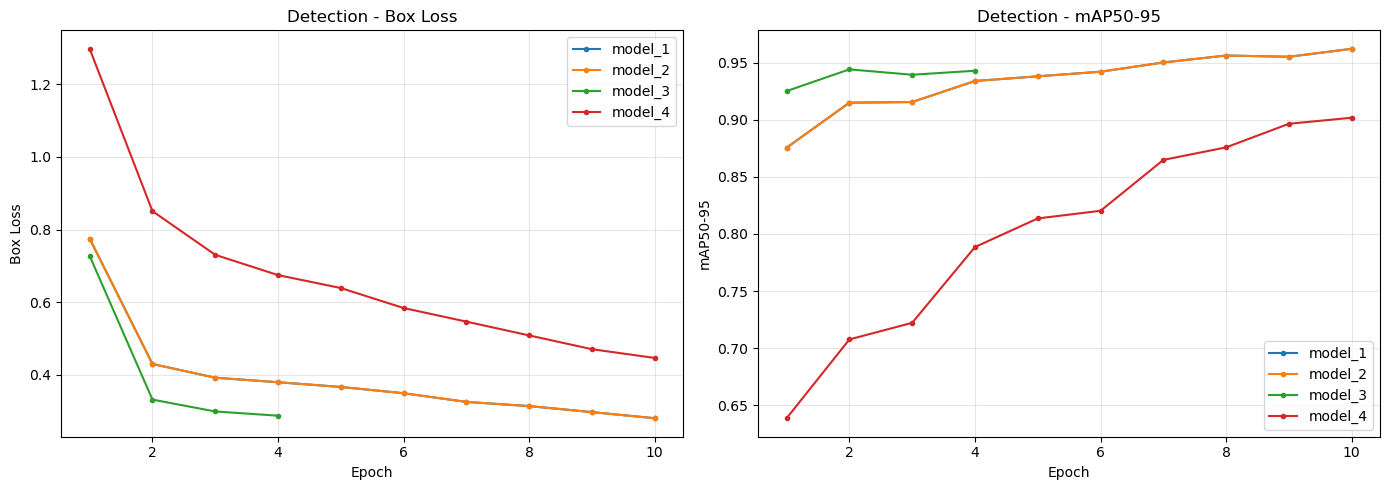

In [15]:
# Plotting Detection Models

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box Loss
for name, df in df_detect.items():
    epochs = df['epoch'].tolist()
    box_loss = df['train/box_loss'].tolist()
    axes[0].plot(epochs, box_loss, label=name, marker='o', markersize=3)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Box Loss')
axes[0].set_title('Detection - Box Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# mAP50-95
for name, df in df_detect.items():
    epochs = df['epoch'].tolist()
    mAP = df['metrics/mAP50-95(B)'].tolist()
    axes[1].plot(epochs, mAP, label=name, marker='o', markersize=3)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('mAP50-95')
axes[1].set_title('Detection - mAP50-95')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

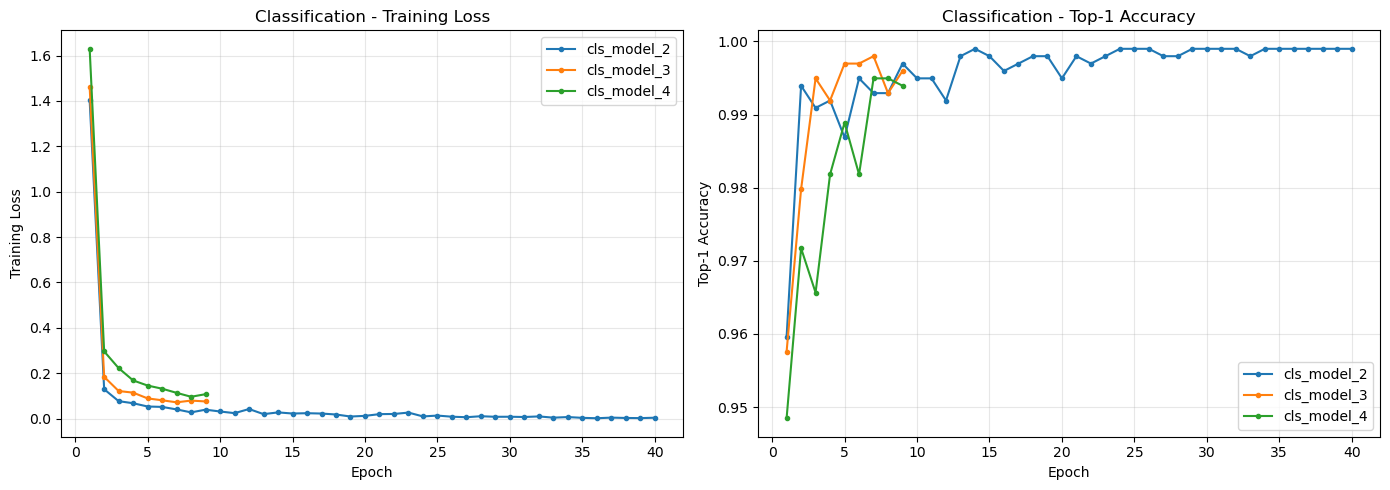

In [16]:
# Plotting Classification Models

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training Loss
for name, df in df_classify.items():
    epochs = df['epoch'].tolist()
    loss = df['train/loss'].tolist()
    axes[0].plot(epochs, loss, label=name, marker='o', markersize=3)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Classification - Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Top-1 Accuracy
for name, df in df_classify.items():
    epochs = df['epoch'].tolist()
    acc = df['metrics/accuracy_top1'].tolist()
    axes[1].plot(epochs, acc, label=name, marker='o', markersize=3)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Top-1 Accuracy')
axes[1].set_title('Classification - Top-1 Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

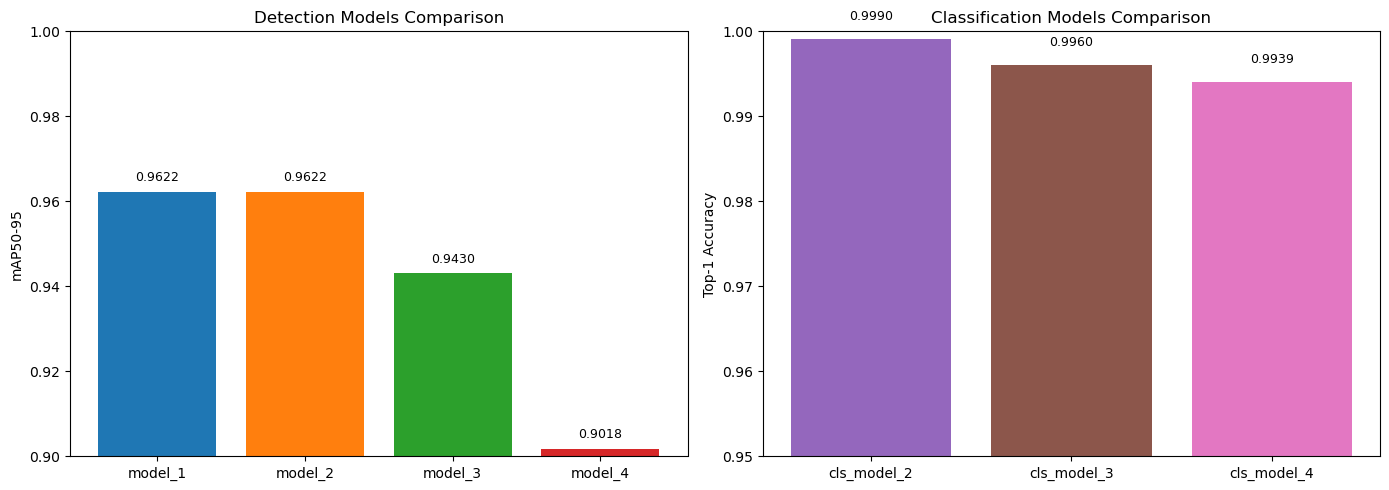

In [17]:
# Model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Detection - mAP50-95 comparison
models = list(df_detect.keys())
mAP_values = [float(df.iloc[-1]['metrics/mAP50-95(B)']) for df in df_detect.values()]
bars = axes[0].bar(models, mAP_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0].set_ylabel('mAP50-95')
axes[0].set_title('Detection Models Comparison')
axes[0].set_ylim(0.9, 1.0)
for bar, val in zip(bars, mAP_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
                 f'{val:.4f}', ha='center', va='bottom', fontsize=9)

# Classification - Top-1 Accuracy comparison
models_cls = list(df_classify.keys())
acc_values = [float(df.iloc[-1]['metrics/accuracy_top1']) for df in df_classify.values()]
bars = axes[1].bar(models_cls, acc_values, color=['#9467bd', '#8c564b', '#e377c2'])
axes[1].set_ylabel('Top-1 Accuracy')
axes[1].set_title('Classification Models Comparison')
axes[1].set_ylim(0.95, 1.0)
for bar, val in zip(bars, acc_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                 f'{val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
